In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML

## Create Regression table

In [2]:
source_path = '/home/mzhang01/google_2022/produce_complete_data/05-assemble-final-results'

In [3]:
'''
Import the var table with sets info
'''
var = pd.read_csv(os.path.join(source_path, 'g2022_adid_var_sets_072024.csv.gz'))

In [4]:
'''
Filter for Gen election period and Set 3
''' 
condition = (var.date_range_end >= '2022-09-01') & (var.date_range_start <= '2022-11-30')
var = var[condition]

var = var[var.set3 == 1]

In [5]:
print(var.shape)
var.columns

(33838, 75)


Index(['ad_id', 'advertiser_id', 'date_range_start', 'date_range_end',
       'num_of_days', 'impressions', 'age_targeting', 'gender_targeting',
       'geo_targeting_included', 'geo_targeting_excluded',
       'spend_range_min_usd', 'spend_range_max_usd', 'aws_face_vid',
       'aws_face_img', 'sub_bucket', 'race_of_focus', 'ad_tone_constructed',
       'ad_tone_mentionbased', 'goal_DONATE_prediction',
       'goal_DONATE_predicted_prob', 'goal_CONTACT_prediction',
       'goal_CONTACT_predicted_prob', 'goal_PURCHASE_prediction',
       'goal_PURCHASE_predicted_prob', 'goal_GOTV_prediction',
       'goal_GOTV_predicted_prob', 'goal_EVENT_prediction',
       'goal_EVENT_predicted_prob', 'goal_POLL_prediction',
       'goal_POLL_predicted_prob', 'goal_GATHERINFO_prediction',
       'goal_GATHERINFO_predicted_prob', 'goal_LEARNMORE_prediction',
       'goal_LEARNMORE_predicted_prob', 'goal_PRIMARY_PERSUADE_prediction',
       'goal_PRIMARY_PERSUADE_predicted_prob', 'goal_highest_prob',
 

### Import pairwise similarity results

In [6]:
'''
Set 3 advertiser-media level General election period data -- candidates
'''
df_cand = pd.read_csv('../output_data/g2022_set3_gen_elect_cand_media_level_average_pairwise_similarity.csv')

'''
Set 3 advertiser-media-race level General election period data -- non-candidate campaign sponsors

'''
df_noncand = pd.read_csv('../output_data/g2022_set3_gen_elect_noncandidate_advertiser_racefocus_media_level_average_pairwise_similarity.csv') 

In [7]:
print(df_noncand.columns)
df_noncand.head(2)

Index(['advertiser_id', 'ad_type', 'race_of_focus', 'cids', 'num_unique',
       'avg', 'std'],
      dtype='object')


,advertiser_id,ad_type,race_of_focus,cids,num_unique,avg,std
0,AR00035659773428891649,IMAGE,LA00,cid_5428 cid_5432,2,0.781259,0.0
1,AR00170851600011624449,IMAGE,MD01,cid_650 cid_652,2,0.116210,0.0


In [8]:
all_sponsor_ids = df_cand.advertiser_id.tolist() + df_noncand.advertiser_id.tolist()

In [9]:
var = var[var.advertiser_id.isin(all_sponsor_ids)]

In [10]:
'''
Import "text" table to get "ad_type"

'''
text_table_path = os.path.join(source_path, 'g2022_adid_01062021_11082022_text_v20240115.csv.gz')
text = pd.read_csv(text_table_path, usecols=['ad_id', 'ad_type', 'advertiser_name'])

In [11]:
var = var.merge(text, how='left', on='ad_id').drop_duplicates()

### Process/explore variables

**Party variables**

In [12]:
'''
Count percentage of sponsors we need to infer party affiliation
'''
print(var[pd.isna(var.party_all)].shape[0]/var.shape[0])

len(var[pd.isna(var.party_all)].groupby('advertiser_id')[['party_all']].first().reset_index().advertiser_id.unique())/len(var.advertiser_id.unique())

0.7138040760663686


0.8854545454545455

In [13]:
var['party_pdid_opt'] = np.where(pd.isna(var.party_all), var.party_all_clf, var.party_all)

**Race competitiveness**: 

SD: safe Dem
DF: Dem favored
LD: Lean Dem
C: Too-close-to-call
LR: Lean Republican
RF: Republican favored
SR: Safe Republican
 
The SD and SR races are coded 1 in house2 (least competitive)
DF and RF are coded 2
LD and LR are coded 3
C is coded 4 (most competitive)

In [14]:
# load race competitiveness index file
race = pd.read_csv('../../race_competitiveness.csv')

In [15]:
var = var.merge(race[['race_code','race_competitiveness']], how='left', left_on='race_of_focus', right_on='race_code')

In [50]:
var.race_competitiveness

0        4.0
1        4.0
2        NaN
3        NaN
4        NaN
        ... 
26393    2.0
26394    2.0
26395    4.0
26396    4.0
26397    4.0
Name: race_competitiveness, Length: 26398, dtype: float64

**campaign resources**

In [16]:
cost = pd.read_csv('../input_data/campaign_resource_gg2022.csv')

In [17]:
'''
Merge to candidate and non-candidate tables
'''
df_cand = df_cand.merge(cost[['advertiser_id', 'estcost']], on='advertiser_id', how='left')
df_noncand = df_noncand.merge(cost[['advertiser_id', 'estcost']], on='advertiser_id', how='left')

In [18]:
'''
Magnitude of estimated cost is too large and nonlinear distribution --> no effects in models
Use logs
'''

df_cand['estcost'] = np.log(df_cand.estcost)
df_noncand['estcost'] = np.log(df_cand.estcost)

### Select regression variables

In [19]:
# Select variables for regression
cols = ['advertiser_id', 'ad_type', 'race_of_focus', 'race_competitiveness', 'party_pdid_opt',
        'wmp_spontype', 'wmp_sen', 'wmp_hse']

In [20]:
data = var[cols]

In [21]:
data.shape

(26398, 8)

In [22]:
data.head(2)

,advertiser_id,ad_type,race_of_focus,race_competitiveness,party_pdid_opt,wmp_spontype,wmp_sen,wmp_hse
0,AR05827288894227349505,VIDEO,CA13,4.0,DEM,campaign,0.0,1.0
1,AR05827288894227349505,VIDEO,CA13,4.0,DEM,campaign,0.0,1.0


### Process regression variables

In [23]:
data.wmp_spontype.unique()

array(['campaign', 'group', 'unclear could be campaign', 'party national',
       'government agency', 'party', 'government official'], dtype=object)

In [24]:
data['image'] = np.where((data.ad_type == 'VIDEO'), 1, 0)
data['video'] = np.where((data.ad_type == 'IMAGE'), 1, 0)

data['party'] = np.where((data.wmp_spontype == 'party') | (data.wmp_spontype == 'party national'), 1, 0)
data['group'] = np.where(data.wmp_spontype == 'group', 1, 0)
data['government'] = np.where(data.wmp_spontype.isin(['government agency', 'government official']), 1, 0)

data['Democratic'] = np.where(data.party_pdid_opt == 'DEM', 1, 0) 
data['third_party'] = np.where(data.party_pdid_opt == 'OTHER', 1, 0) 

data.loc[:, 'race_of_focus'] = data.race_of_focus.fillna('')
data['senate'] = np.where((data.wmp_sen == 1) | (data.race_of_focus.str.endswith('S0')), 1, 0)

/tmp/ipykernel_25581/334181364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['image'] = np.where((data.ad_type == 'VIDEO'), 1, 0)
/tmp/ipykernel_25581/334181364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['video'] = np.where((data.ad_type == 'IMAGE'), 1, 0)
/tmp/ipykernel_25581/334181364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [26]:
# aggregate at the advertiser level
agg = data.groupby(['advertiser_id', 'ad_type']).mean(numeric_only=True).reset_index()

### Candidates regression table

In [27]:
df_cand = df_cand.merge(agg, on=['advertiser_id', 'ad_type'], how='left')

In [28]:
df_cand.rename(columns={'avg': 'AverageSimilarity'}, inplace=True)

In [29]:
df_cand['candidate'] = 1

In [30]:
df_cand.columns

Index(['advertiser_id', 'ad_type', 'cids', 'AverageSimilarity', 'std',
       'num_unique', 'estcost', 'race_competitiveness', 'wmp_sen', 'wmp_hse',
       'image', 'video', 'party', 'group', 'government', 'Democratic',
       'third_party', 'senate', 'candidate'],
      dtype='object')

In [31]:
df_cand.shape

(506, 19)

### Non-candidates regression table

In [32]:
'''
Get variables for regression table for non-candidate sponsors (grouped by race of focus)

Aggregate at advertiser_id, ad_type, race_of_focus level
'''
 
agg2 = data.groupby(['advertiser_id', 'ad_type', 'race_of_focus']).mean(numeric_only=True).reset_index()

In [33]:
df_noncand = df_noncand.merge(agg2, on=['advertiser_id', 'ad_type', 'race_of_focus'], how='left')

df_noncand.rename(columns={'avg': 'AverageSimilarity'}, inplace=True)

In [34]:
df_noncand['candidate'] = 0

In [35]:
df_noncand.columns

Index(['advertiser_id', 'ad_type', 'race_of_focus', 'cids', 'num_unique',
       'AverageSimilarity', 'std', 'estcost', 'race_competitiveness',
       'wmp_sen', 'wmp_hse', 'image', 'video', 'party', 'group', 'government',
       'Democratic', 'third_party', 'senate', 'candidate'],
      dtype='object')

In [37]:
df_noncand.shape

(688, 20)

### Combine candidates only and non-candidates sponsors grouped by race of focus

In [39]:
df = pd.concat([df_cand, df_noncand.drop("race_of_focus", axis=1)])

In [40]:
# 2022 general election cycle: Sept ~ Nov 2022
df.to_csv('../input_data/gg_regression_table_for_descriptives.csv', index=False)

In [118]:
df.columns

Index(['advertiser_id', 'ad_type', 'cids', 'AverageSimilarity', 'std',
       'num_unique', 'estcost', 'race_competitiveness', 'wmp_sen', 'wmp_hse',
       'image', 'video', 'party', 'group', 'government', 'Democratic',
       'third_party', 'senate', 'candidate'],
      dtype='object')

## Import created regression table directly

In [4]:
df = pd.read_csv('../input_data/gg_regression_table_for_descriptives.csv')

In [5]:
df.shape

(1194, 19)

In [6]:
df_cand = df[df.candidate == 1]

### Subset of sponsors who invested in TV ads

In [41]:
df.rename(columns={'estcost': 'log_estimated_cost'}, inplace=True)

In [42]:
df_cost = df[~pd.isna(df.log_estimated_cost)]

In [43]:
print(df.shape)
print(df_cost.shape)

(1194, 19)
(728, 19)


In [44]:
df_cand_cost = df_cost[(df_cost.candidate == 1)]
print(df_cand_cost.shape)

(364, 19)


## Create DV (Sophistication index)

In [45]:
def create_sophistication_index(input_df):
    max_ = input_df.num_unique.max()
    min_ = input_df.num_unique.min()
    input_df['num_unique_normalized'] = (input_df.num_unique - min_)/(max_ - min_)
    input_df['sophistication_index'] = input_df['num_unique_normalized'] * (1 - input_df.AverageSimilarity)
    return input_df

In [46]:
df = create_sophistication_index(df)
df_cand = create_sophistication_index(df_cand)

In [47]:
df_cost = create_sophistication_index(df_cost)
df_cand_cost = create_sophistication_index(df_cand_cost)

/tmp/ipykernel_25581/1499460830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['num_unique_normalized'] = (input_df.num_unique - min_)/(max_ - min_)
/tmp/ipykernel_25581/1499460830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['sophistication_index'] = input_df['num_unique_normalized'] * (1 - input_df.AverageSimilarity)
/tmp/ipykernel_25581/1499460830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## Regression

### DV: sophistication index

In [78]:
import statsmodels.api as sm

In [48]:
df_cand = df_cand.drop_duplicates(subset=['advertiser_id', 'ad_type', 'sophistication_index'])

In [60]:
rename_labels = {'senate': 'Senate', 'race_competitiveness': 'Race competitiveness', 
                  'third_party': 'Third party', 
                 'log_estimated_cost': 'TV ad spending (logged)', 
                 'party': 'Party', 'group': 'Group', 
                 'government': 'Other sponsor type',
                 'image': 'Image', 'video': 'Video',}

In [55]:
# for house/senate candidates only 
form1 = "sophistication_index ~ senate + race_competitiveness \
        + Democratic + third_party + video + image"

form2 = "sophistication_index ~ senate + race_competitiveness \
        + Democratic + third_party + log_estimated_cost \
        + video + image"

model1 = smf.ols(formula=form1, data=df_cand).fit()
model2 = smf.ols(formula=form2, data=df_cand_cost).fit()

In [56]:
# DV: sophistication index, Candidates Only
'''
Current display is general election period. 
'''
cov_order = ['senate', 'race_competitiveness',
             'Democratic', 'third_party', 'log_estimated_cost', 
             'video', 'image', 'Intercept'] 

stargazer = Stargazer([model1, model2])
stargazer.covariate_order(cov_order)
stargazer.rename_covariates(rename_labels)
display(HTML(stargazer.render_html()))

In [61]:
# for all sponsors, non-campaign sponsors grouped by race of focus
form3 = "sophistication_index ~ senate + party + group + government + race_competitiveness \
        + Democratic + third_party + video + image"

form4 = "sophistication_index ~ senate + party + group + government + race_competitiveness \
        + Democratic + third_party + log_estimated_cost \
        + video + image"

model3 = smf.ols(formula=form3, data=df).fit()
model4 = smf.ols(formula=form4, data=df_cost).fit()

In [63]:
# DV: sophistication index, Candidates + non-candidates grouped by race of focus
'''
Current display is general election period
'''

cov_order = ['senate', 'party', 'group', 'government', 'race_competitiveness',
             'Democratic', 'third_party', 'log_estimated_cost', 
             'video', 'image', 'Intercept'] 

stargazer = Stargazer([model3, model4])
stargazer.covariate_order(cov_order)
stargazer.rename_covariates(rename_labels)
display(HTML(stargazer.render_html()))

### Main effects plots

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [73]:
def plot_coefficents(m1, m2, offset=-0.15):
    '''
      Inputs: 
          m1, m2: two OLS regression models
    '''
    coefficients1 = m1.params
    conf1 = m1.conf_int()
    conf1['coef'] = coefficients1
    conf1.columns = ['lower', 'upper', 'coef']
    conf1['model'] = 'Model 1'

    coefficients2 = m2.params
    conf2 = m2.conf_int()
    conf2['coef'] = coefficients2
    conf2.columns = ['lower', 'upper', 'coef']
    conf2['model'] = 'Model 2'
    
    conf12 = pd.concat([conf1, conf2])
    conf12.rename(index=rename_labels, inplace=True)
    conf12 = conf12[conf12.index != 'Intercept']
    
    # Add offset to separate the models
    conf12['y_offset'] = conf12.groupby(conf12.index).cumcount() * offset
    
    labels = list(conf12.index.unique()[::-1])

    y_steps = {}
    for i, label in enumerate(labels):
        y_steps[label] = i

    conf12['y_step'] = conf12.index.map(y_steps)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots()

    colors=['black', 'gray']

    for i, model in enumerate(conf12.model.unique()):
        curr_coef = conf12[conf12.model == model]
        ax.errorbar(y=curr_coef['y_offset'] + curr_coef['y_step'], 
                     x=curr_coef['coef'], 
                     xerr=(curr_coef['upper'] - curr_coef['lower']) / 2, 
                     fmt='o', 
                     markersize = 5,
                     color=colors[i])



    # Create legend
    handle1 = mlines.Line2D([], [], color='black', linestyle='-', marker='o', markersize=4, label='Model 1')
    handle2 = mlines.Line2D([], [], color='gray', linestyle='-', marker='o', markersize=4, label='Model 2')
    ax.legend(handles=[handle1, handle2], loc='best')

    # Format yticks labels and other labels
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.title('')
    plt.ylabel('Predictor')
    plt.xlabel('Coefficient')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()

<Figure size 1200x800 with 0 Axes>

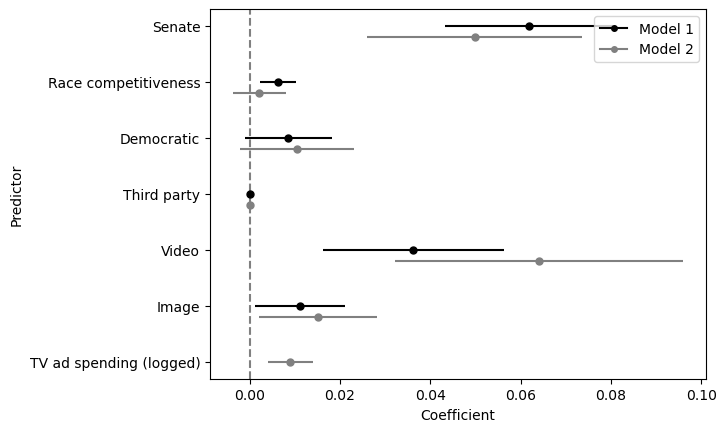

In [74]:
plot_coefficents(model1, model2, offset=-0.2)

<Figure size 1200x800 with 0 Axes>

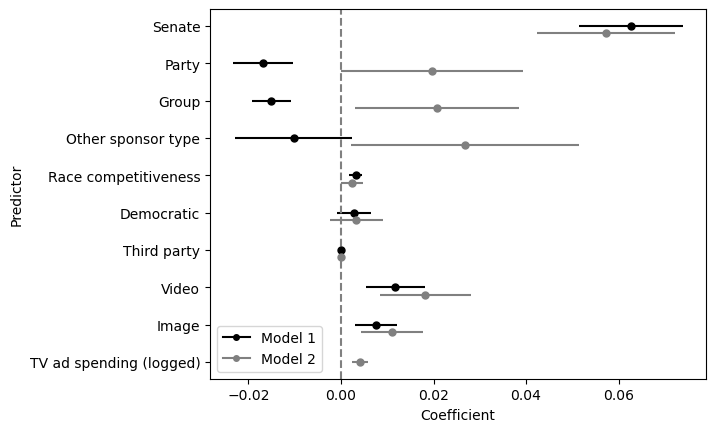

In [75]:
plot_coefficents(model3, model4, offset=-0.2)